# Statistics

> Scripts to generate statistics out of orbit data

In [ ]:
#| default_exp stats

In [ ]:
#| export
#| hide
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import umap.umap_ as umap
from typing import List, Any, Dict

In [ ]:
#| hide
from fastcore.test import test_eq

## Simple statistics

In [ ]:
#| export
def calculate_overall_statistics(orbits: np.ndarray  # The array containing orbit data of shape (number_of_orbits, 6, number_of_time_instants).
                                 ) -> Dict[str, Dict[str, float]]:
    """
    Calculate the overall min, mean, max, and percentile statistics for each scalar 
    (position and velocity in X, Y, Z) across all time instants and orbits.

    Parameters:
    - orbits (np.ndarray): A numpy array of shape (number_of_orbits, 6, number_of_time_instants) containing orbit data.

    Returns:
    - Dict[str, Dict[str, float]]: A dictionary with statistics ('min', 'mean', 'max', '25%', '50%', '75%') for each scalar.
    """
    stats = {}  # Dictionary to store statistics for each scalar.
    scalar_names = ['posx', 'posy', 'posz', 'velx', 'vely', 'velz']  # List of scalar names for positions and velocities.
    
    for scalar_index, scalar_name in enumerate(scalar_names):
        scalar_data = orbits[:, scalar_index, :].flatten()  # Flatten data to combine all orbits and time points for each scalar.
        
        # Calculate statistics for the current scalar and store them in the dictionary.
        stats[scalar_name] = {
            'min': np.min(scalar_data),  # Minimum value.
            'mean': np.mean(scalar_data),  # Mean value.
            'max': np.max(scalar_data),  # Maximum value.
            '25%': np.percentile(scalar_data, 25),  # 25th percentile.
            '50%': np.median(scalar_data),  # Median, equivalent to the 50th percentile.
            '75%': np.percentile(scalar_data, 75)  # 75th percentile.
        }
    
    return stats  # Return the dictionary containing all calculated statistics.

In [ ]:
#| test "basic functionality"
orbits = np.array([
    [[1, 2, 3], [2, 3, 4], [3, 4, 5], [4, 5, 6], [5, 6, 7], [6, 7, 8]],  # Orbit 1
    [[4, 4, 4], [3, 4, 5], [4, 5, 6], [5, 6, 7], [6, 7, 8], [7, 8, 9]]   # Orbit 2
])

# Call the function to calculate statistics
stats = calculate_overall_statistics(orbits)

# Using test_eq to perform tests
test_eq(stats['posx']['min'], 1)
test_eq(stats['posx']['mean'], 3)
test_eq(stats['posx']['max'], 4)
test_eq(stats['posx']['25%'], 2.25)
test_eq(stats['posx']['50%'], 3.5)
test_eq(stats['posx']['75%'], 4)

## Plot Histograms

In [ ]:
#| export
def plot_orbit_data_lengths(orbit_data, key_range=(1, 36072), dimension=0, bins=30, color='blue', plot=True, title='Histogram of Orbits Time Steps'):
    lengths = []
    
    # Iterate over each dataset name within the provided range
    start, end = key_range  # Unpack the tuple for range
    for key in range(start, end):
        if key in orbit_data:
            try:
                # Append the length of the specified dimension of the dataset
                lengths.append(len(orbit_data[key][dimension]))
            except IndexError:
                # Handle the case where the dimension is not available
                print(f"Warning: Dimension {dimension} is not available in dataset {key}.")
                continue
    
    if plot:
        # Plot the histogram of these lengths if plot is True
        plt.figure(figsize=(10, 6))
        plt.hist(lengths, bins=bins, color=color, edgecolor='black')
        plt.title(title)
        plt.xlabel('Time Steps')
        plt.ylabel('Frequency')
        plt.show()
    else:
        # Return lengths data for further analysis
        return lengths

In [ ]:
#| export
def plot_histograms_position(data: np.ndarray  # The orbit data array of shape (num_orbits, 6, num_time_points).
                            ) -> None:
    """
    Plots histograms for the 6 scalar values (position and velocity in X, Y, Z) across all orbits and time points.
    """
    scalar_names = ['posX', 'posY', 'posZ', 'velX', 'velY', 'velZ']
    num_scalars = len(scalar_names)
    
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))  # Adjust the subplot layout as necessary
    fig.suptitle('Histograms of Position and Velocity Components Across All Orbits')
    
    for i in range(num_scalars):
        scalar_values = data[:, i, :].flatten()  # Flatten combines all orbits and time points for each scalar
        
        row, col = divmod(i, 3)  # Determine subplot position
        axs[row, col].hist(scalar_values, bins=50, alpha=0.75)  # You can adjust the number of bins
        axs[row, col].set_title(f'{scalar_names[i]}')
        axs[row, col].set_ylabel('Frequency')
        axs[row, col].set_xlabel('Value')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the main title
    plt.show()

In [ ]:
#| test
from orbit_generation.data import get_example_orbit_data

In [ ]:
#| test
orbit_data = get_example_orbit_data()
orbit_data.shape

(200, 6, 300)

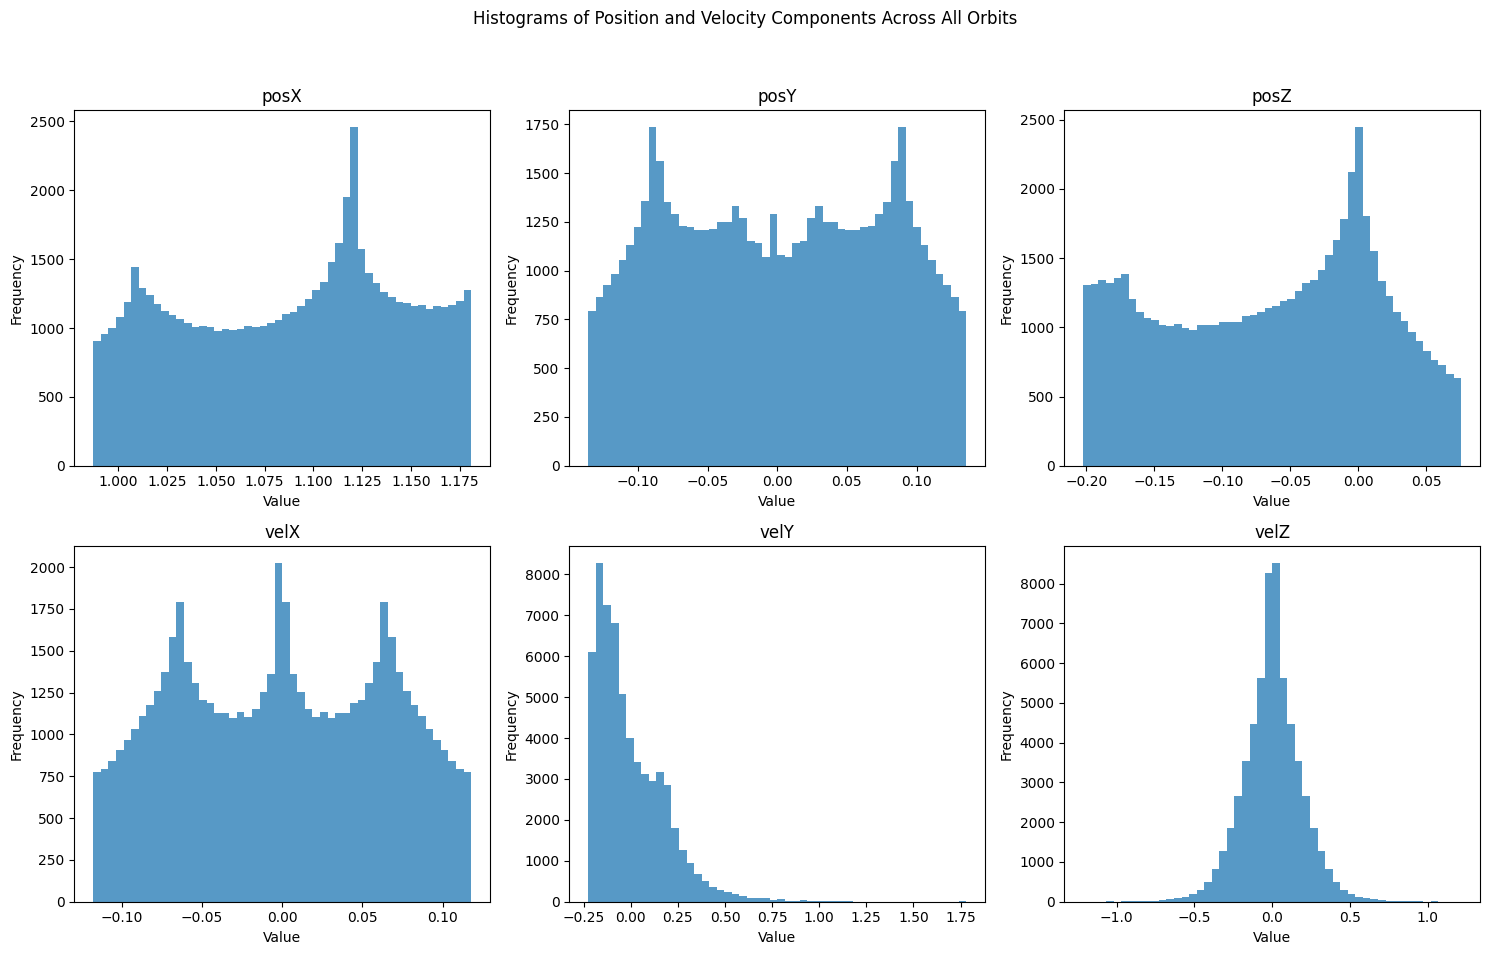

In [ ]:
#| test plot_histograms_position
plot_histograms_position(orbit_data)

In [ ]:
#| export
def plot_histograms_comparison(data1: np.ndarray,  # First orbit data array of shape (num_orbits, 6, num_time_points).
                               data2: np.ndarray,  # Second orbit data array of shape (num_orbits, 6, num_time_points).
                               ) -> None:
    """
    Plots histograms for the 6 scalar values (position and velocity in X, Y, Z) from two datasets on the same chart with different colors.

    Parameters:
    - data1 (np.ndarray): First orbit data array.
    - data2 (np.ndarray): Second orbit data array.
    """
    scalar_names = ['posX', 'posY', 'posZ', 'velX', 'velY', 'velZ']
    num_scalars = len(scalar_names)
    
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))  # Create a grid of 2x3 subplots
    fig.suptitle('Comparative Histograms of Position and Velocity Components')

    # Define colors for the histograms
    colors = ['blue', 'green']  # First dataset in blue, second in green
    
    for i in range(num_scalars):
        # Flatten the data to combine all orbits and time points for each scalar
        scalar_values1 = data1[:, i, :].flatten()
        scalar_values2 = data2[:, i, :].flatten()
        
        # Determine subplot position
        row, col = divmod(i, 3)
        
        # Plot histograms for each dataset on the same subplot
        axs[row, col].hist(scalar_values1, bins=50, alpha=0.75, color=colors[0], label='Dataset 1')
        axs[row, col].hist(scalar_values2, bins=50, alpha=0.75, color=colors[1], label='Dataset 2')
        
        axs[row, col].set_title(f'{scalar_names[i]}')
        axs[row, col].set_ylabel('Frequency')
        axs[row, col].set_xlabel('Value')
        axs[row, col].legend()  # Add a legend to differentiate between datasets
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the main title
    plt.show()

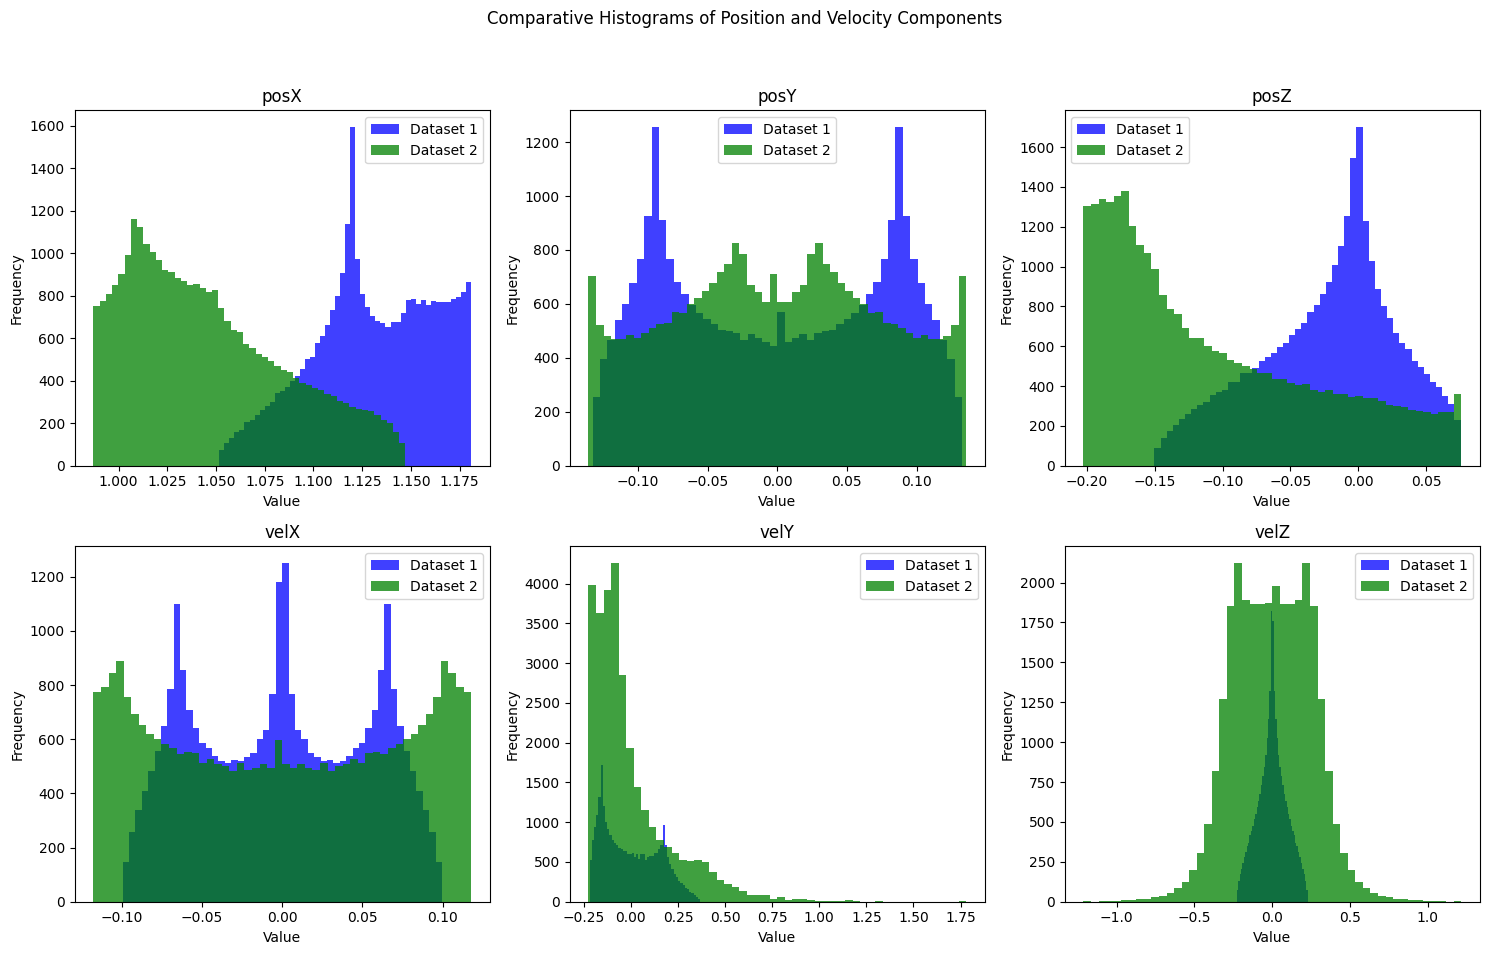

In [ ]:
#| test plot_histograms_comparison
orbit_data1 = orbit_data[:100]
orbit_data2 = orbit_data[100:]

plot_histograms_comparison(orbit_data1, orbit_data2)

## Latent Space

In [ ]:
#| export
def plot_latent_space(latent_representations: np.ndarray,  # Precomputed latent representations (numpy array).
                      labels: np.ndarray,  # Labels for the data points, used for coloring in the plot.
                      techniques: List[str] = ['PCA'],  # Techniques to use for reduction ('PCA', 't-SNE', 'UMAP', 'LDA').
                      n_components: int = 2,  # Number of dimensions to reduce to.
                      figsize: tuple = (12, 9),  # Size of the figure for each subplot.
                      n_colors: int = 30,  # Number of unique colors to use in the colormap.
                      **kwargs: Any  # Additional keyword arguments for dimensionality reduction methods.
                      ) -> None:
    """
    Plots the latent space representations using specified dimensionality reduction techniques.
    This function supports multiple dimensionality reduction techniques including PCA, t-SNE, UMAP, and LDA.
    It can be configured to plot one or multiple techniques simultaneously for comparative visualization, displayed vertically.
    """
    models: Dict[str, Any] = {
        'PCA': PCA(n_components=n_components),
        't-SNE': TSNE(n_components=n_components, **kwargs),
        'UMAP': umap.UMAP(n_components=n_components, **kwargs),
        'LDA': LinearDiscriminantAnalysis(n_components=n_components)
    }

    if 'All' in techniques:
        techniques = list(models.keys())

    if len(techniques) > 1:
        fig, axes = plt.subplots(len(techniques), 1, figsize=(figsize[0], figsize[1] * len(techniques)))  # Adjusted for vertical display
        if len(techniques) == 1:
            axes = [axes]  # Ensure axes is iterable in the case of a single plot.
    else:
        plt.figure(figsize=figsize)

    for i, technique in enumerate(techniques):
        model = models.get(technique)
        if not model:
            continue

        if technique == 'LDA':
            results = model.fit_transform(latent_representations, labels)
        else:
            results = model.fit_transform(latent_representations)

        ax = axes[i] if len(techniques) > 1 else plt.gca()
        cmap = colormaps['nipy_spectral'].resampled(n_colors)  # Resampled colormap for distinct coloring
        scatter = ax.scatter(results[:, 0], results[:, 1], alpha=0.6, c=labels, cmap=cmap, s=30)
        ax.set_xlabel(f'{technique} Dimension 1')
        ax.set_ylabel(f'{technique} Dimension 2')
        ax.set_title(f'Visualization with {technique}')

    if len(techniques) > 1:
        fig.colorbar(scatter, ax=axes[-1], ticks=range(n_colors), label='Classes').set_ticklabels(range(1, n_colors + 1))

    plt.tight_layout()
    plt.show()

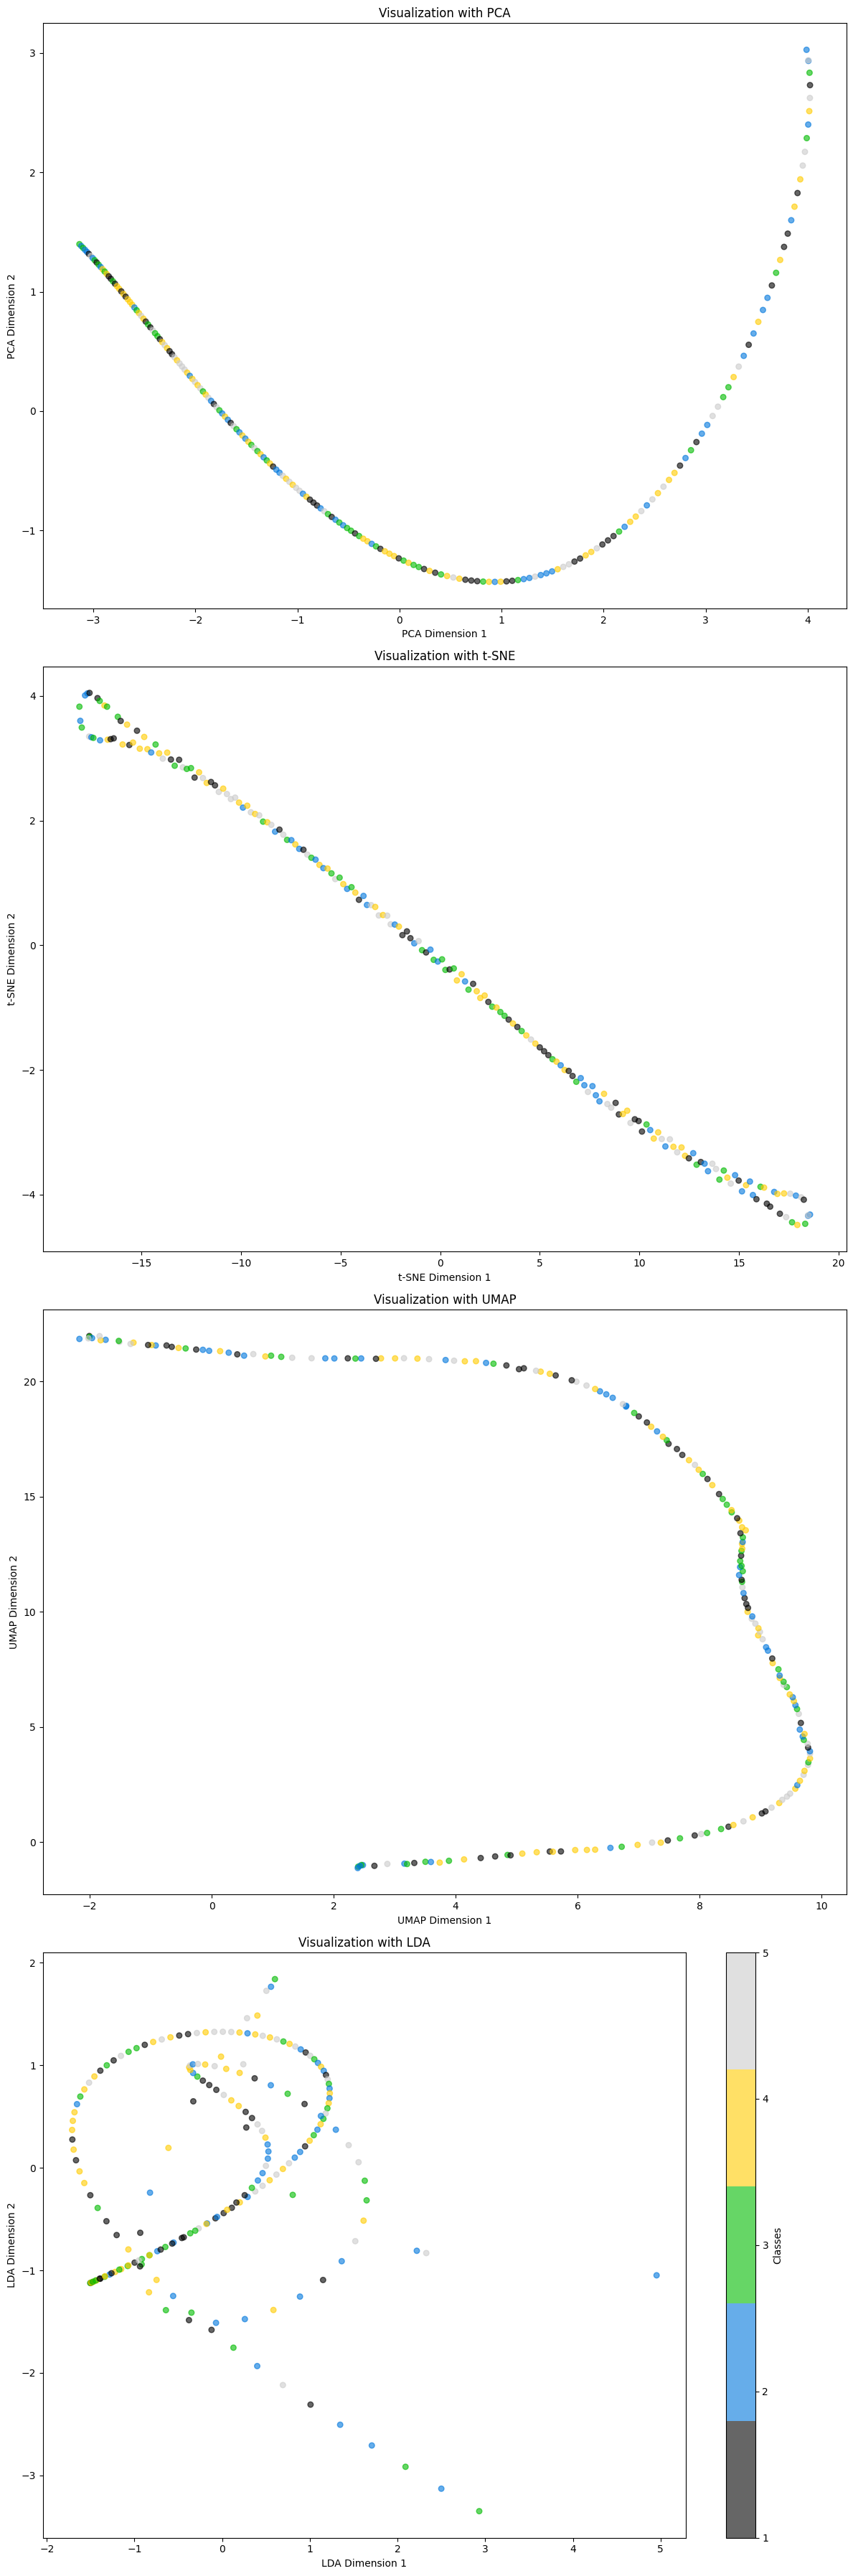

In [ ]:
#| test plot_latent_space

# Reshape data to 2D (num_orbits, 6 * num_time_points)
orbit_data_reshaped = orbit_data.reshape(200, -1)

# Use PCA to reduce to a lower-dimensional space (e.g., 10 dimensions)
pca = PCA(n_components=10)
latent_representations = pca.fit_transform(orbit_data_reshaped)

labels = np.random.randint(0, 5, size=200)  # 5 different classes

plot_latent_space(latent_representations, labels, n_colors=5, techniques=['All'])

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()